In [1]:
import os
import bisect
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
from RSCpp import IOfuncs as iof
from RSCpp import RheoConfig as rconf
from RSCpp import RheoCorr as rcorr
from RSCpp import FTrheo as ft
from RSCpp import AnalysisFuncs as af
from RSCpp import SharedFunctions as sf
from pathlib import Path

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger = logging.getLogger('matplotlib')
logger.setLevel(logging.WARNING)
logging.info('ShearCell postproc tutorial started')

C:\Users\steaime\miniconda3\envs\DSH\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
INFO:root:ShearCell postproc tutorial started


# Shear cell rheology post processing

This tutorial explains how to load and analyze rheology experiments done with the shear cell

### 1. Locate data and reconstruct rheology protocol

Data should be in the output folder of the rheology program. Three types of files should be in there:

- ```Config_Rheo.ini```: the configuration file used by the rheology program
- ```expLog.txt```: the log file with the list of the intervals that have been generated by the rheology program
- A list of file with name structure ```PREFIX[a][_POS/NEG].txt```, with:
  - ```PREFIX``` a prefix specified in the ```Name``` field of ```expLog.txt```
  - ```[a]``` a character suffix that counts how many times that interval has been repeated
  - ```[_POS/NEG]``` eventually, another suffix to distinguish positive and negative ramps

Information on rheology protocol is lodaded in ```RheoConfig.RheoProtocol``` object using the function

```python
rconf.RheoProtocol(config_folder, config_fname='Config_Rheo.ini', explog_fname='expLog.txt')
```

In [2]:
froot = r'D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\04_Weekend'
rheo_protocol = rconf.RheoProtocol(froot)
print(rheo_protocol)

INFO:root:2249 rows read from expLog file D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\04_Weekend\expLog.txt
INFO:root:expLog file updated with 2248 output file paths


<RheoProtocol (223 intervals)>


This object can be used to reconstruct a dataset with each interval's setting, including the output file path, using 

```python
RheoProtocol.LoadExpLog(force_reload=False, load_fnames=True)
```

**NOTE**: this file path is reconstructed based on the assumption that the file naming hasn't changed. This assumption can be wrong for old data. 

The program checks if the reconstructed file path corresponds to a file that really exists.

In [3]:
rheo_explog = rheo_protocol.LoadExpLog()
rheo_explog

,ID,Time,Type,Name,Force,Displacement,Speed,Period,Offset,RelOffset,...,StartPos,EndPos,StartForce,EndForce,Trigger,Active,Axis,StrainControlled,FilePath,FilePath_exists
0,1,0.233438,4,01_FlowCurve_000,<err>,1,10,<err>,0,1,...,12.0008,13.0008,0.00357524,-0.0185141,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
1,1,0.467239,4,01_FlowCurve_000,<err>,1,10,<err>,0,1,...,13.0008,12.0008,-0.0166173,0.0219382,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
2,2,0.800024,4,01_FlowCurve_001,<err>,1,5.62341,<err>,0,1,...,12.0008,13.0008,0.0196051,-0.0169698,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
3,2,1.0916,4,01_FlowCurve_001,<err>,1,5.62341,<err>,0,1,...,13.0008,12.0008,-0.0148717,0.0233985,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
4,3,1.54417,4,01_FlowCurve_002,<err>,1,3.16228,<err>,0,1,...,12.0008,13.0008,0.0193197,-0.0180609,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2243,21,1220.47,0,223_Relax_020,<err>,0.01,0.0628319,1,0,1,...,12.0021,12.0021,0.0004532,0.000856044,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
2244,225,1630.95,2,224_Step_AX1_OSR0.04_000,<err>,1,<err>,100,0,1,...,12.0021,12.0021,0.000553911,0.00194708,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
2245,225,2041.35,2,224_Step_AX1_OSR0.04_000,<err>,1,<err>,100,0,1,...,12.0021,12.0021,0.00177923,0.000772118,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
2246,225,2451.8,2,224_Step_AX1_OSR0.04_001,<err>,1,<err>,100,0,1,...,12.0021,12.0021,0.000604266,0.00208136,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True


The result is a ```pandas.DataFrame```, with a list of columns

In [4]:
rheo_explog.columns

Index(['ID', 'Time', 'Type', 'Name', 'Force', 'Displacement', 'Speed',
       'Period', 'Offset', 'RelOffset', 'Phase', 'Duration', 'StartTime',
       'StartedOn', 'EndedOn', 'StartPos', 'EndPos', 'StartForce', 'EndForce',
       'Trigger', 'Active', 'Axis', 'StrainControlled', 'FilePath',
       'FilePath_exists'],
      dtype='object')

Each column is a ```pandas.Series```

In [5]:
rheo_explog['Duration']

0            0.1
1            0.1
2       0.177828
3       0.177828
4       0.316228
          ...   
2243           3
2244         800
2245         800
2246         800
2247         800
Name: Duration, Length: 2248, dtype: object

Explog data can be accessed using standard methods

In [6]:
float(rheo_explog['Duration'][0])

0.1

In [7]:
duration_nparr = rheo_explog['Duration'].to_numpy(dtype=float)
duration_nparr[0]

0.1

Dataframes can be filtered also. This filters all constant-speed measurements (```Type==4```) with moving small motor (```AxisID==1```):

In [8]:
rheo_explog[(rheo_explog['Type'] == '4') & (rheo_explog['Axis'] == '1')]

,ID,Time,Type,Name,Force,Displacement,Speed,Period,Offset,RelOffset,...,StartPos,EndPos,StartForce,EndForce,Trigger,Active,Axis,StrainControlled,FilePath,FilePath_exists
0,1,0.233438,4,01_FlowCurve_000,<err>,1,10,<err>,0,1,...,12.0008,13.0008,0.00357524,-0.0185141,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
1,1,0.467239,4,01_FlowCurve_000,<err>,1,10,<err>,0,1,...,13.0008,12.0008,-0.0166173,0.0219382,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
2,2,0.800024,4,01_FlowCurve_001,<err>,1,5.62341,<err>,0,1,...,12.0008,13.0008,0.0196051,-0.0169698,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
3,2,1.0916,4,01_FlowCurve_001,<err>,1,5.62341,<err>,0,1,...,13.0008,12.0008,-0.0148717,0.0233985,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
4,3,1.54417,4,01_FlowCurve_002,<err>,1,3.16228,<err>,0,1,...,12.0008,13.0008,0.0193197,-0.0180609,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
5,3,1.97143,4,01_FlowCurve_002,<err>,1,3.16228,<err>,0,1,...,13.0008,12.0007,-0.0157781,0.023516,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
6,4,2.66567,4,01_FlowCurve_003,<err>,1,1.77828,<err>,0,1,...,12.0007,13.0008,0.0196219,-0.0197058,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
7,4,3.33241,4,01_FlowCurve_003,<err>,1,1.77828,<err>,0,1,...,13.0007,12.0007,-0.0180776,0.0265374,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
8,5,4.47129,4,01_FlowCurve_004,<err>,1,1,<err>,0,1,...,12.0007,13.0007,0.0210318,-0.0190008,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True
9,5,5.60795,4,01_FlowCurve_004,<err>,1,1,<err>,0,1,...,13.0007,12.0007,-0.0157445,0.0242882,0,1,1,1,D:\steaime\Data\RheoSALS\250507_newRheo_Ortho\...,True


### 2. Read and plot raw data

To load raw output data for a given interval, use:

```python
RheoProtocol.ReadRheoData(self, row_index, usecols=(1,2,6), unpack=True, **loadtxt_kwargs)
```

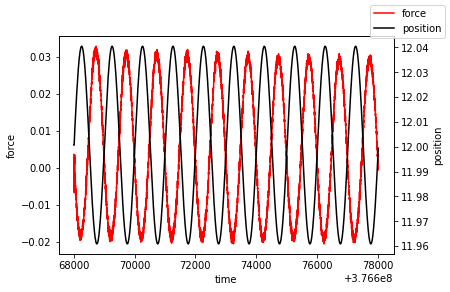

In [9]:
fidx = 40
int_time, int_pos, int_force = rheo_protocol.ReadRheoData(fidx, usecols=(1, 5, 6))
if int_pos is not None:
    fig, ax = plt.subplots()
    ax.plot(int_time, int_force, 'r-', label='force')
    ax.set_xlabel('time')
    ax.set_ylabel('force')
    ax2 = ax.twinx()
    ax2.plot(int_time, int_pos, 'k-', label='position')
    ax2.set_ylabel('position')
    fig.legend()

### 3. Batch process multiple files

One useful way to batch process multiple files of one given type is:

```python
AnalysisFuncs.BatchProcess(explog_data, filter_type=None, filter_axis=None, filter_name=None, max_num=None, usecols=None, anal_type='count', anal_params={})
```

where:

- ```filter_type```, ```filter_axis``` and ```filter_name```, if not ```None```, filter the explog DataFrame based on type, axis and name
- ```max_num``` eventually limits the number of files to be processed
- ```usecols``` specifies the columns to be read as $(t, \gamma, \sigma)$. They typically are ```(1,2,6)``` when large motor is used as actuator and small motor is used as strain sensor, or ```(1,5,6)``` when small motor is both applying the strain and measuring the stress
- ```anal_type```: one of ```['count' (default), 'read', 'plot', 'FT', 'OSR', 'flowcurve', 'avgperiod']```:
  - ```'count'```: returns the number of result files with the given filter criteria
  - ```'read'```: returns raw time, displacement and force data 
  - ```'plot'```: plots raw data. Additional parameters to be specified in ```anal_params```:
      - ```'plot_type'```: type of plot. One of ```['time' (default), 'stressstrain', 'stressrelax']```:
        - ```'time'```: x: time, left y: displacement, right y: force
        - ```'stressstrain'```: x: displacement, y: force
        - ```'stressrelax'```: x: time (log), y: force
      - ```'fmt'```: format of matplotlib plot. Default is ```'-'```, a solid line
      - ```'t0'```: reference time, in seconds, to offset raw times (that are relative to first point in the dataset). Default: 0
  - ```'FT'```: Fourier analysis of oscillatory data. Additional parameters to be specified in ```anal_params```:
    - ```'nperiods'```: number of oscillations to be analyzed at once. Default: total number of periods - 2
    - ```'Tres_Step'```: if specified, compute time-dependent moduli by analyzing a limited number of periods, on a sliding window with width ```anal_params['Tres_Nint']``` and step ```'Tres_Step'```, in units of the period. If not set, don't perform time-dependent analysis
    - ```'Tres_Nint'```: number of oscillations to be analyzed at once in time-dependent analysis. Default: 1
  - ```'OSR'```: Fourier analysis of orthogonal superposition oscillatory data. Additional parameters to be specified in ```anal_params```:
    - ```'nperiods'```, ```'Tres_Step'```, ```'Tres_Nint'```: see above
    - ```'OSRparams'```: ```dict``` with two entries: ```'Period'```, ```'Amp'```, with period and amplitude of the orthogonal oscillation
    - ```'OSRparam_list'```: eventually, a list of ```dict```, one per interval, containing interval-specific parameters
  - ```'flowcurve'```: average force on a range of displacements corresponding to steady state to extract flow curve. Averaging displacement range (in mm) is specified as a 2 elements list in ```anal_params['displ_range']=[d_min, d_max]```
  - ```'avgperiod'```: average strain and stress on a period (typically useful to obtain smooth Lissajous plots out of oscillatory experiments). Additional parameters to be specified in ```anal_params```:
    - ```'PeriodIdx'```: number of datapoints corresponding to one period
    - ```'StartIdx'```: start from the Nth datapoint (skipping the ones before). Default: 0
    - ```'EndIdx'```: skip the last N datapoint. Default: 0
- ```anal_params```: ```dict``` with additional parameters used by the analysis, as specified above

The function returns:

- if ```anal_type=='count'```: the number of files (```ìnt```)
- if ```anal_type=='read'```: a list of three-element lists with time, position and force data (```float``` arrays)
- if ```anal_type=='plot'```: the matplotlib plot (```plt.figure```)
- if ```anal_type in ['FT', 'OSR']```: a table of FT results, one row per output file, with following columns: ```[Time, Amplitude, Period, Offset, Force_amp, Force_phase, Displ_amp, Displ_phase, k_amp, k_phase, k_real, k_imag, Force_Avg, OSR_Period, OSR_Amp]```, where ```k=-Force/Displacement```, the minus sign accounting for third Newton's law. **NOTE**: if time-dependent analysis is performed (```anal_params['Tres_Step']``` is specified), time-dependent results are automatically exported to an ASCII file with the same name as the raw input file and suffix ```_tresFT``` or ```_tresOSR```, depending on the analysis type.
- if ```anal_type=='flowcurve'```: two float arrays: ```Speed, AvgForce``` 
- if ```anal_type=='avgperiod'```: a 2D array with shape ```[anal_params['PeriodIdx'], 2*num_files+1]```, first column being intra-cycle time, and then period-averaged strain and stress, two columns per raw file

### 4a. Application to shear startup experiments

In [10]:
af.BatchProcess(rheo_explog, filter_type=4, filter_axis=1, anal_type='count')

INFO:root:Auto-detected suffix length: 1 (34 files detected)


34

INFO:root:Auto-detected suffix length: 1 (34 files detected)


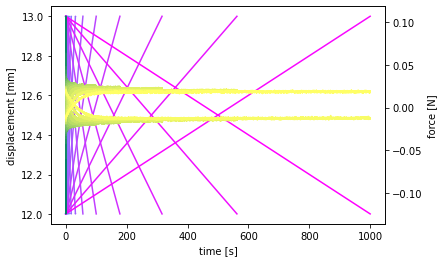

In [11]:
_ = af.BatchProcess(rheo_explog, filter_type=4, filter_axis=1, anal_type='plot')

INFO:root:Auto-detected suffix length: 1 (34 files detected)


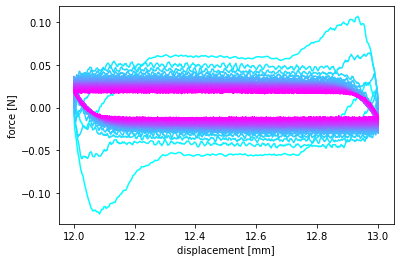

In [12]:
_ = af.BatchProcess(rheo_explog, filter_type=4, filter_axis=1, anal_type='plot', anal_params={'plot_type': 'stressstrain'})

INFO:root:Auto-detected suffix length: 1 (34 files detected)


Text(0, 0.5, 'F [N]')

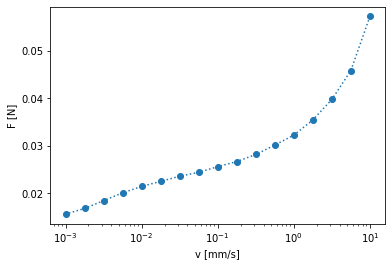

In [13]:
v, F = af.BatchProcess(rheo_explog, filter_type=4, filter_axis=1, anal_type='flowcurve', anal_params={'displ_range':[0.4,0.6]})
fig, ax = plt.subplots()
ax.plot(v[::2], np.abs(0.5*(F[1::2]-F[::2])), 'o:')
ax.set_xscale('log')
ax.set_xlabel('v [mm/s]')
ax.set_ylabel('F [N]')

### 4b. Application to oscillatory shear experiments

INFO:root:Auto-detected suffix length: 1 (21 files detected)


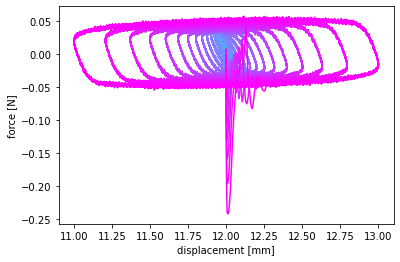

In [14]:
_ = af.BatchProcess(rheo_explog, filter_type=0, filter_axis=1, filter_name='StrainSweep_1Hz', 
                    max_num=21, anal_type='plot', anal_params={'plot_type': 'stressstrain'})

In [15]:
periodavg = af.BatchProcess(rheo_explog, filter_type=0, filter_axis=1, filter_name='StrainSweep_0.1Hz', max_num=21, anal_type='avgperiod', 
                       anal_params={'StartIdx':500, 'EndIdx':-500, 'PeriodIdx':1000})
np.savetxt(os.path.join(froot, 'DSS_0.1Hz_Periodavg.dat'), periodavg, delimiter='\t', 
            header='time[s]\t' + '\t'.join(['d{0}\tF{0}'.format(i) for i in range((periodavg.shape[1]-1)//2)]))

INFO:root:Auto-detected suffix length: 1 (21 files detected)


In [16]:
tlen = 8
DSS_1Hz_FTres = af.BatchProcess(rheo_explog, filter_type=0, filter_axis=1, filter_name='StrainSweep_1Hz', anal_type='FT', anal_params={'nperiods':tlen})
np.savetxt(os.path.join(froot, 'DSS_1Hz_FTres_T' + str(tlen).zfill(2) + '.dat'), DSS_1Hz_FTres, delimiter='\t', 
            header='time\tamplitude\tperiod\toffset\tF_abs\tF_phase\tx_abs\tx_phase\tk_abs\tk_phase\tk_real\tk_imag\tF_avg\tOSR_period\tOSR_amp')
DSS_0p1Hz_FTres = af.BatchProcess(rheo_explog, filter_type=0, filter_axis=1, filter_name='StrainSweep_0.1Hz', anal_type='FT', anal_params={'nperiods':tlen})
np.savetxt(os.path.join(froot, 'DSS_0.1Hz_FTres_T' + str(tlen).zfill(2) + '.dat'), DSS_0p1Hz_FTres, delimiter='\t', 
            header='time\tamplitude\tperiod\toffset\tF_abs\tF_phase\tx_abs\tx_phase\tk_abs\tk_phase\tk_real\tk_imag\tF_avg\tOSR_period\tOSR_amp')

INFO:root:Auto-detected suffix length: 1 (42 files detected)
INFO:root:Auto-detected suffix length: 1 (168 files detected)


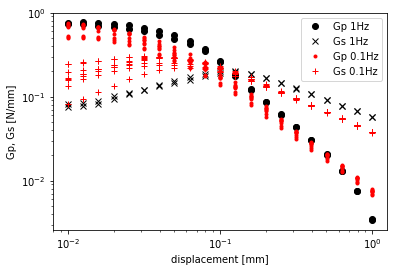

In [17]:
fig, ax = plt.subplots()
ax.plot(DSS_1Hz_FTres[:,1], DSS_1Hz_FTres[:,10], 'ko', label='Gp 1Hz')
ax.plot(DSS_1Hz_FTres[:,1], DSS_1Hz_FTres[:,11], 'kx', label='Gs 1Hz')
ax.plot(DSS_0p1Hz_FTres[:,1], DSS_0p1Hz_FTres[:,10], 'r.', label='Gp 0.1Hz')
ax.plot(DSS_0p1Hz_FTres[:,1], DSS_0p1Hz_FTres[:,11], 'r+', label='Gs 0.1Hz')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('displacement [mm]')
ax.set_ylabel('Gp, Gs [N/mm]')
ax.legend()

In [18]:
Relax_FTres = af.BatchProcess(rheo_explog, filter_type=0, filter_axis=1, filter_name='Relax', anal_type='FT', anal_params={'nperiods':1})
np.savetxt(os.path.join(froot, 'Relax_FTres.dat'), Relax_FTres, delimiter='\t', 
            header='time\tamplitude\tperiod\toffset\tF_abs\tF_phase\tx_abs\tx_phase\tk_abs\tk_phase\tk_real\tk_imag\tF_avg\tOSR_period\tOSR_amp')

INFO:root:Auto-detected suffix length: 1 (1428 files detected)


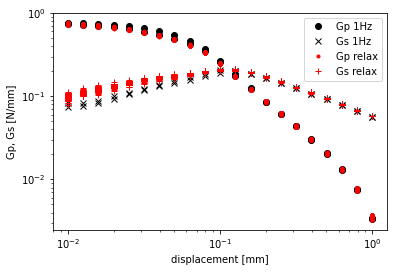

In [19]:
fig, ax = plt.subplots()
ax.plot(DSS_1Hz_FTres[:,1], DSS_1Hz_FTres[:,10], 'ko', label='Gp 1Hz')
ax.plot(DSS_1Hz_FTres[:,1], DSS_1Hz_FTres[:,11], 'kx', label='Gs 1Hz')
ax.plot(Relax_FTres[:,1], Relax_FTres[:,10], 'r.', label='Gp relax')
ax.plot(Relax_FTres[:,1], Relax_FTres[:,11], 'r+', label='Gs relax')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('displacement [mm]')
ax.set_ylabel('Gp, Gs [N/mm]')
ax.legend()

### 4c. Application to stress relaxation experiments

In [20]:
af.BatchProcess(rheo_explog, filter_type=2, anal_type='count')

INFO:root:Auto-detected suffix length: 0 (264 files detected)


264

INFO:root:Auto-detected suffix length: 0 (132 files detected)


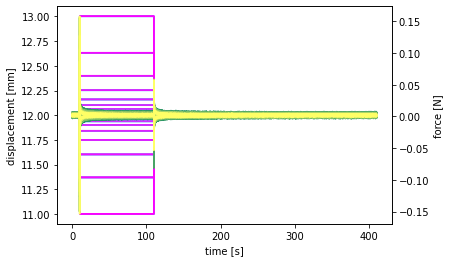

In [22]:
_ = af.BatchProcess(rheo_explog, filter_type=2, filter_axis=1, anal_type='plot')

INFO:root:Auto-detected suffix length: 0 (132 files detected)


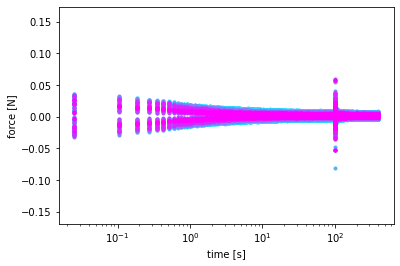

In [23]:
_ = af.BatchProcess(rheo_explog, filter_type=2, filter_axis=1, anal_type='plot', anal_params={'plot_type': 'stressrelax', 't0':10.1, 'fmt':'.'})

In [24]:
res_relax = []
osr_list = ['OSR0.01', 'OSR0.02', 'OSR0.04']
for osr_filter in osr_list:
    res_relax.append(af.BatchProcess(rheo_explog, filter_type=2, filter_axis=1, filter_name=osr_filter, anal_type='read'))

INFO:root:Auto-detected suffix length: 0 (44 files detected)
INFO:root:Auto-detected suffix length: 0 (44 files detected)
INFO:root:Auto-detected suffix length: 0 (44 files detected)


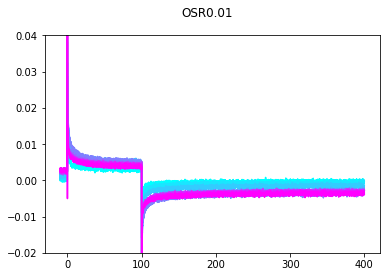

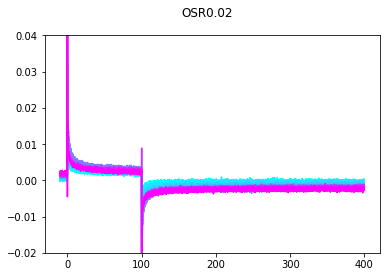

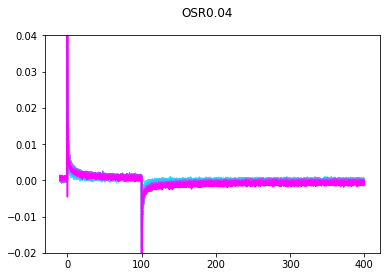

In [25]:
for oidx in range(len(res_relax)):
    fig, ax = plt.subplots()
    ax.set_prop_cycle(color=plt.cm.cool(np.linspace(0,1,int(len(res_relax[oidx])//4))))
    for i in range(0, len(res_relax[oidx]), 4):
        common_len = np.min([len(res_relax[oidx][i+j][2]) for j in range(4)])
        res_avg = -res_relax[oidx][i][2][:common_len]
        for j in range(1,4):
            res_avg += res_relax[oidx][i+j][2][:common_len]*(-1)**(j+1)
        res_avg /= 4
        ax.plot((res_relax[oidx][i][0][:common_len]-res_relax[oidx][i][0][0])/1000-10.1, res_avg)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_ylim([-0.02, 0.04])
    fig.suptitle(osr_list[oidx])

### 4d. Application to Orthogonal Superposition Rheology (OSR) experiments

In [26]:
print(rheo_protocol.intervals[201].OSR)

{'Type': 'OSCILL_POS', 'Amp': 0.04, 'Period': 1.0}


In [28]:
osr_dss_intlist = rheo_protocol.FilterIntervals({'type':'OSCILL_POS', 'axID':0, 'hasOSR':True})
osr_dss_fnames = rconf.GetIntervalFilenames(osr_dss_intlist, rheo_protocol.config_folder)
DSS_OSR_FTres = af.BatchProcess(rheo_explog, anal_type='OSR', anal_params={'OSRparam_list':[x.OSR for x in osr_dss_intlist]})#, 'Tres_Step':0.1})

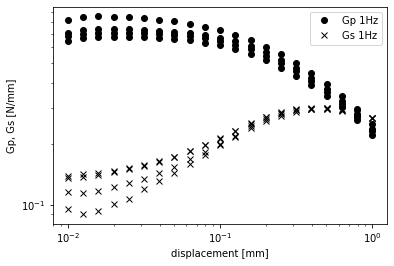

In [29]:
fig, ax = plt.subplots()
ax.plot(DSS_OSR_FTres[:,1], DSS_OSR_FTres[:,10], 'ko', label='Gp 1Hz')
ax.plot(DSS_OSR_FTres[:,1], DSS_OSR_FTres[:,11], 'kx', label='Gs 1Hz')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('displacement [mm]')
ax.set_ylabel('Gp, Gs [N/mm]')
ax.legend()